<a href="https://colab.research.google.com/github/vitorbeltrao/TimeSeries_Passenger_Forecast/blob/main/Previs%C3%A3o_de_passageiros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*by [Vitor Beltrão](https://www.linkedin.com/in/v%C3%ADtor-beltr%C3%A3o-56a912178/)*

---

# Séries Temporais - Previsões Utilizando Redes Neurais 

**As séries temporais estão por toda a parte!** Você as viu em preços de ações, previsões do tempo, em tendências históricas e demandas. Poderíamos ficar horas exemplificando onde as séries temporais estão presentes, então vamos em frente!

<p align=center>
<img src="https://images.unsplash.com/photo-1501139083538-0139583c060f?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=750&q=80" width="50%"></p>

Mas, o que exatamente é uma série temporal?

**É uma sequência ordenada de valores, geralmente espaçadas igualmente ao longo do tempo todos os anos, meses, dias ou mesmo a cada poucos microssegundos.**

As séries temporais, vem com diversas formas e tamanhos, mas alguns padrões são mais comuns do que outros, portanto, é bastante útil reconhecê-los. Um desses padrões, é a **tendência**. Um série temporal, pode ter uma tendência de alta ou de baixa, por exemplo, as vendas de uma loja ao longo do tempo, podem estar aumentando ou diminuindo.

Outro padrão muito importante, é a **sazonalidade**. Ela se define quando os padrões de um determinado conjunto de dados se repetem em intervalos previsíveis, com "picos" e "vales" específicos nos gráficos. Por exemplo, as vendas de uma loja de chocolate, aumentam consideravelmente (picos) na época de pascoa, mas caem bruscamente durante as férias de verão (vales) e isso se repete todos os anos.

Por fim, outro padrão que é interessante reconhecer, é o **ruído**. Dessa forma, as séries ficam completamente imprevisíveis. Um exemplo, seria o ruído branco, nele, seria interessante encontrar apenas sua distribuição de probabilidade e os seus parâmetros, como a média e a variância.

* Quando temos um único valor, em cada intervalo de tempo, dizemos que é uma série temporal **univariada**.

* Quando temos mais de um valor, em cada intervalo de tempo, dizemos que é uma série temporal **multivariada**.

Como podemos ver, a série temporal pode ser utilizada para analisar quase tudo que evolui ao longo do tempo. Ela possui diversas aplicações, sendo a mais comum a **previsão**.

**Este, portanto, será o objetivo desse projeto. Utilizar os dados de uma companhia aérea para prever a quantidade de passageiros que ela terá.**






## Aquisição dos dados

Os dados deste trabalho foram adquiridos do [Kaggle](https://www.kaggle.com/rakannimer/air-passengers). Lá você encontra esse e outros datasets muito interessantes para fazer projetos como esse ou até participar de competições entre cientistas de dados.

In [1]:
# Importar os pacotes necessários.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df = pd.read_csv("https://raw.githubusercontent.com/vitorbeltrao/TimeSeries_Passenger_Forecast/main/data/AirPassengers.csv")

## Análise Exploratória dos dados

Vamos, em primeiro lugar, fazer um reconhecimento do nosso dataset por meio da análise exploratória. Sabemos o quanto essa etapa de um projeto é importante!

<p align=center>
<img src="https://images.unsplash.com/photo-1527474305487-b87b222841cc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=667&q=80" width="50%"></p>

* Vamos começar verificando as 5 primeiras entradas do dataset.

In [2]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Esse é um dataset que possui apenas duas colunas. **Note como é nítido uma análise de série temporal, nesse caso**. Temos uma coluna com uma sequência de valores (passageiros) ao longo de um período de tempo (meses). Vamos verificar esses valores em um gráfico para tudo ficar mais claro. 

Antes da análise gráfica, vamos verificar os tipos das duas colunas, a quantidade de valores ausentes e alterar o que for necessário.

* Verificar os tipos das colunas

In [3]:
df["Month"] = pd.to_datetime(df["Month"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Aqui alteramos o tipo da coluna 'Month' para 'datetime', pois, como é uma coluna que representa as datas do conjunto de dados, esse é o tipo correto a se trabalhar.

A coluna 'Passengers' se encontra como 'int'. Esse é também o tipo correto a se trabalhar com essa coluna, já que temos números inteiros em suas entradas.

* Vamos verificar a ausência de algum dado, bem como renomear as nossas colunas e passar a coluna que representa as datas (Month) para o index do dataframe.

In [4]:
df.set_index("Month", inplace=True)
df.columns = ["passengers"]
df.index.name = "date"

print('Quantidade de linhas e colunas:', df.shape)
print('Quantidade de dados nulos:', df.isna().sum().sum())

df.head()

Quantidade de linhas e colunas: (144, 1)
Quantidade de dados nulos: 0


,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Esse conjunto de dados não possui nenhum valor ausente, o que é ótimo para nossa análise. **Ressalto que esse é um passo importante**. Se por acaso existir um dado nulo em uma determinada data e isso representar uma queda drástica no gráfico, nossa análise se modificará completamente.

Feito isso, podemos partir para análises mais profundas!

<p align=center>
<img src="https://image.freepik.com/free-vector/site-stats-concept-illustration_114360-1434.jpg" width="30%"></p>

* Verificação do aumento de passageiros por período de mês e aceleração desse aumento.



In [5]:
df_2 = df.copy()
df_2['aumento'] = df_2['passengers'].diff()
df_2['aceleracao'] = df_2['aumento'].diff()
df_2.head()

,passengers,aumento,aceleracao
date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


Aqui, criamos um novo dataframe com algumas colunas novas. Essas novas colunas 'aumento' e 'aceleracao' nos dizem o quanto de passageiros aumentou (ou diminuiu) de um intervalo de tempo para o outro e com qual aceleração esse aumento aconteceu, respectivamente.

Os valores em ambas, são apenas a subtração de um valor em determinada data com a data anterior. A coluna 'aumento' tem seus valores vindo da coluna 'passengers' e a coluna 'aceleracao' tem seus valores vindo da coluna 'aumento'.

* Vamos plotar um gráfico para verificar esses valores.

In [6]:
def plot_comparacao(x, y1, y2, y3, dataset, titulo):
  plt.figure(figsize=(16,12))
  ax = plt.subplot(3,1,1)
  ax.set_title(titulo, fontsize=18,loc='left')
  sns.lineplot(x=x, y=y1, data=dataset)
  plt.subplot(3,1,2)
  sns.lineplot(x=x, y=y2, data=dataset)
  plt.subplot(3,1,3)
  sns.lineplot(x=x, y=y3, data=dataset)
  ax = ax

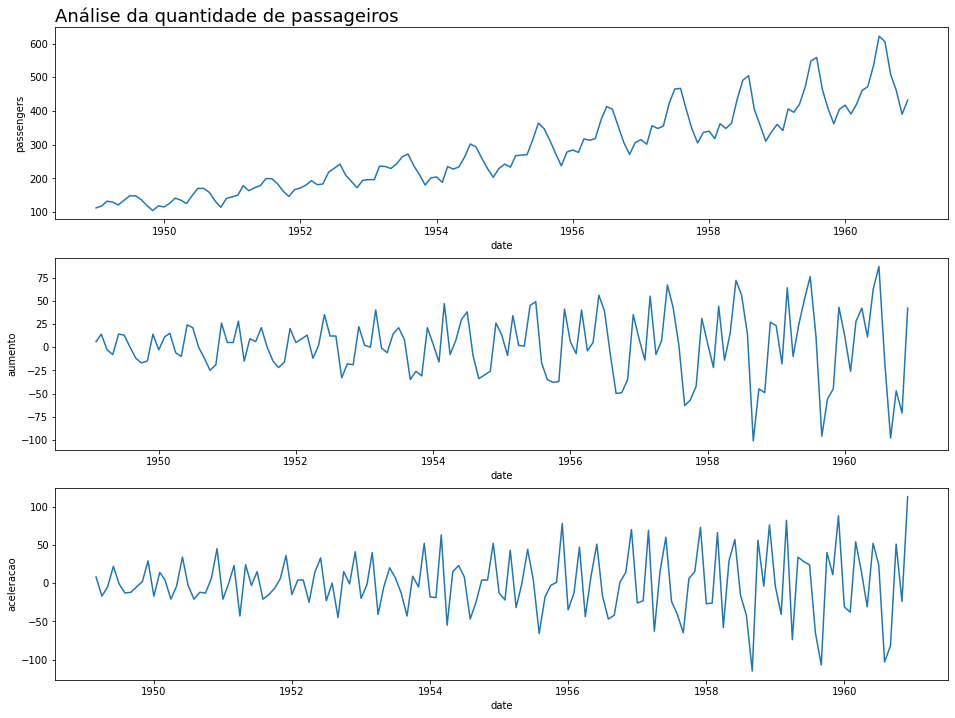

In [7]:
plot_comparacao('date', 'passengers', 'aumento', 'aceleracao',
               df_2, 'Análise da quantidade de passageiros')

Conseguimos ver claramente pelo primeiro gráfico (tempo x passageiros) uma nítida série temporal. Note que é um gráfico que possui padrões de **tendência** e **sazonalidade**.

Nesse caso, temos uma tendência ascendente, visto que o número de passageiros está aumentando ao longo do tempo.

Temos também uma sazonalidade bem perceptível. Note que ao longo do mesmo intervalo de tempo (mais ou menos), temos "picos" e "vales" bem característicos no gráfico. Os picos estão acontecendo, provavelmente, devido a determinadas datas mais propícias a viajar (Como nas férias escolares) e os vales exatamente ao contrário.

Com relação aos ruídos, percebemos melhor pelo terceiro gráfico, na relação tempo x aceleração. Veja como o gráfico apenas "sobe" e "desce" de maneira desordenada, deixando uma certa imprevisibilidade na análise.


## Modelo de Machine Learning

### Particionamento Fixo

Após fazer todas as análises na etapa anterior, temos condições de finalmente montar nosso algoritmo de machine learning.

A abordagem mais simples é pegar o último valor e supor que o próximo valor será o mesmo. Isso é chamado de **"previsão ingênua"**. Muitas vezes é interessante utilizar essa previsão ingênua, apenas para obter uma linha de base do desempenho do modelo.

Para medir o desempenho do modelo de previsão, o ideal é dividir a série temporal em um período de treinamento, um período de validação e outro de teste. **Isso é chamado de particionamento fixo.**

Se a série temporal tiver alguma sazonalidade, geralmente, temos que garantir que cada período contenha um número inteiro de "temporadas", como, um ano, dois anos, três anos, etc. Não queremos um ano e meio ou dois anos e meio, pois, alguns meses seriam mais representativos do que outros, causando uma confusão na análise.

Vamos descrever aqui um passo a passo do algoritmo:

* Primeiro, deve-se treinar o modelo no **período de treinamento**;
* Depois, deve-se avalia-lo no **período de validação**. Aqui podemos itera-lo várias vezes (entre o período de treinamento e validação) para achar uma boa arquitetura da nossa rede neural e ajustar os hyperparâmetros;
* Após finalizar os dois primeiros passos, teste o modelo no **período de teste**, para ter uma ideia de como será o desempenho do modelo em produção.

<p align=center>
<img src="https://github.com/vitorbeltrao/Pictures/blob/main/train_test_validation.png?raw=true" width="80%"></p>


**Nem sempre teremos um excelente desempenho, porque a série temporal pode se comportar de maneira diferente no futuro, mas geralmente conseguiremos desempenhos razoáveis e aplicáveis.**

* Para fechar o nosso passo a passo, devemos treinar a série temporal uma última vez, incluindo nesse treino o período que antes era de teste, para implantar o modelo. **Isso é diferente das práticas recomendadas usuais de machine learning, onde nunca treinamos no período de teste.** 

Aqui, contrariando as práticas recomendadas, isso vai ser necessário, pois, o período mais recente da série temporal costuma ser o que mais contém informações úteis para a previsão.

<p align=center>
<img src="https://github.com/vitorbeltrao/Pictures/blob/main/train_test_validation_2.png?raw=true" width="80%"></p>

Agora, como o período de teste não é tão confiável quanto nas práticas usuais de machine learning, porque precisamos usá-lo para treinamento antes de implantar o modelo, é comum utilizar apenas um período de treinamento e um de validação. **Em outras palavras, o período de teste estará no futuro.**

### Particionamento Rollforward

O particionamento fixo é simples e intuitivo, mas há outra maneira de fazer previsões. **O particionamento rollforward.**

Nesse método, começamos com um curto período de treinamento e gradualmente aumentamos, um dia de cada vez ou uma semana de cada vez. A cada iteração, treinamos o modelo no **período de treinamento** e o usamos para prever o dia seguinte ou a semana seguinte no **período de validação**.

**Sua desvantagem é que exigirá muito mais tempo de treinamento, mas o benefício é que será mais próximo de imitar as condições de produção, pois você geralmente irá treinar regularmente o modelo a medida que novos dados são obtidos na produção.**

<font color='red'>Para simplificar, neste projeto iremos seguir com o particionamento fixo.</font>






In [8]:
from sklearn.preprocessing import MinMaxScaler
train=df[:132]
val=df[132:]
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_val=scaler.transform(val)

print("Dados de treino:", train)
print("Dados de teste:", val)

Dados de treino:             passengers
date                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405

[132 rows x 1 columns]
Dados de teste:             passengers
date                  
1960-01-01         417
1960-02-01         391
1960-03-01         419
1960-04-01         461
1960-05-01         472
1960-06-01         535
1960-07-01         622
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432


Esses são os nossos dados de treino e validação respectivamente. Reservamos os últimos doze meses dos dados para a validação. Também fizemos uma normalização para melhorar o desempenho do modelo.

Antes de treinar nosso modelo final, vamos criar um baseline utilizando a previsão ingênua. **Vamos utilizar o mean squared error como métrica de avaliação.**

### Previsão ingênua

In [9]:
df['passengers']
df['naive'] = df['passengers'].shift(1)

df_naive = df[['passengers','naive']][1:]

In [10]:
from sklearn.metrics import mean_squared_error

naive_true = df_naive['passengers']
naive_prediction = df_naive['naive']
print("MSE:\t", mean_squared_error(naive_true, naive_prediction))

MSE:	 1136.3916083916083


Temos o baseline pela previsão ingênua! Vamos então treinar o algoritmo utilizando as redes neurais.

### Modelo Final - LSTM

LSTM (Long Short-Term Memory) é uma arquitetura baseada em Rede Neural Recorrente (RNN) que é amplamente usada no processamento de linguagem natural e previsão de séries temporais. **O LSTM corrige um grande problema que as redes neurais recorrentes sofrem: memória curta.**

Vamos então ao que interessa!


In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')
model.summary()

model.fit(generator,epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
120/120 [==============================] - 7s 26ms/step - loss: 0.0461
Epoch 2/30
120/120 [==============================] - 3s 23ms/step - loss: 0.0214
Epoch 3/30
120/120 [

Treinamos a nossa rede, e, para finalizar vamos fazer previsões e comparar o desempenho com o baseline.

In [12]:
lstm_predictions_scaled = list()

batch = scaled_train[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(val)):   
    lstm_pred = model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

[array([0.6293784], dtype=float32),
 array([0.63328695], dtype=float32),
 array([0.71266], dtype=float32),
 array([0.7157723], dtype=float32),
 array([0.79497975], dtype=float32),
 array([0.95490235], dtype=float32),
 array([1.0825005], dtype=float32),
 array([1.0470113], dtype=float32),
 array([0.84040225], dtype=float32),
 array([0.70675486], dtype=float32),
 array([0.6584201], dtype=float32),
 array([0.71501493], dtype=float32)]

In [13]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[390.36716217],
       [392.1455636 ],
       [428.26030666],
       [429.67638338],
       [465.71578676],
       [538.48056966],
       [596.53770828],
       [580.39012158],
       [486.38302171],
       [425.57346278],
       [403.58113909],
       [429.33179522]])

In [14]:
val['LSTM_Predictions'] = lstm_predictions
val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,passengers,LSTM_Predictions
date,,
1960-01-01,417,390.367162
1960-02-01,391,392.145564
1960-03-01,419,428.260307
1960-04-01,461,429.676383
1960-05-01,472,465.715787
1960-06-01,535,538.480570
1960-07-01,622,596.537708
1960-08-01,606,580.390122
1960-09-01,508,486.383022


Aqui estão nossas predições! Vamos dar uma olhada graficamente e calcular seu desempenho na métrica que adotamos.

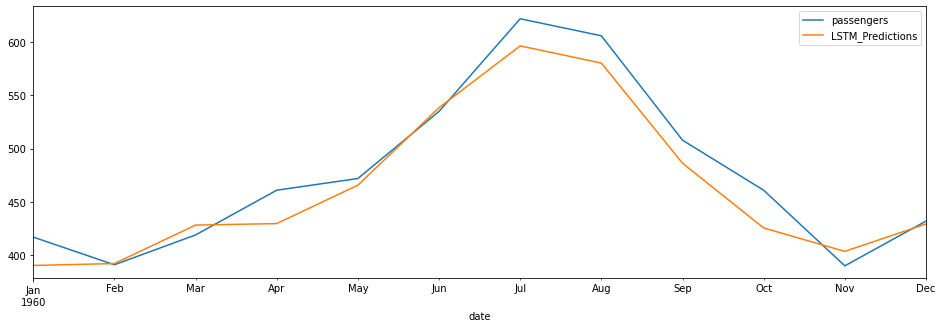

In [15]:
val['passengers'].plot(figsize = (16,5), legend=True)
val['LSTM_Predictions'].plot(legend = True);

In [16]:
val = val['passengers'].values
print("MSE:\t", mean_squared_error(val, lstm_predictions))

MSE:	 420.6035352755564


Vejam o desempenho na métrica adotada, veja como o erro caiu quase pela metade! Nada mal, não é mesmo?






## Conclusão

**Independente das vantagens/desvantagens de usar uma rede neural sobre os métodos clássicos, gostaria de pontuar algumas coisas:**

1. É muito importante pesar o custo/benefício de usar um modelo complexo versus um modelo mais simples. Um ligeiro aumento na precisão pode não valer o tempo, esforço e perda de interpretabilidade introduzidos pelos modelos mais complexos.

2. Existem muitas outras técnicas que podemos utilizar, como os modelos ARIMA e suas vertentes. Essa última, em muitos casos geralmente superam os modelos de machine learning para séries temporais.

3. Com todas essas diversas possibilidades de criar um modelo preditivo, ressalto a importância de sempre realizar diversos testes de pré-processamento dos dados, de testar algoritmos diferentes (que enquadrem na solução) e também do tunning dos hiperparâmetros. Dificilmente iremos encontrar uma solução ótima logo de primeira, na prática esses testes fazem parte do trabalho.

Para fechar, ressalto o quanto a previsão de séries temporais é complexa. Caso contrário o mercado de ações estaria resolvido. Há um elemento inerente de ruído em todos os dados de série temporal que não podemos capturar de forma viável, assim como fatores externos incontroláveis, independente do quão bom seja o modelo.

**Espero ter contribuído!**